## About This Data

**Dataset Name:** Animal Faces-HQ (AFHQ)

**Description:**
- This dataset consists of **16,130 high-quality images** at a **512×512** resolution.
- It contains images across **three domains**, each providing around **5,000 images**.
- The dataset is designed to create a **challenging image-to-image translation problem**, offering **diverse breeds** per domain.

**Domains (Classes):**
- 🐱 **Cat**
- 🐶 **Dog**
- 🦁 **Wildlife**

This is how you can download the data remotely:
```python

!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/andrewmvd/animal-faces")

# 2. Imports
Lets start by getting all our imports, keep in mind that PyTorch is not automatically detects and trains on GPU, you have to tell it to use cuda. In case you want to train on Mac Silicon replace cuda with mps.


In [42]:
from calendar import EPOCH

import torch  # Main PyTorch Library
from pandas.conftest import axis_1
from tenacity import retry_unless_exception_type
from torch import nn  # Used for creating the layers and loss function
from torch.optim import Adam  # Adam Optimizer
import torchvision.transforms as transforms  # Transform function used to modify and preprocess all the images
from torch.utils.data import Dataset, DataLoader  # Dataset class and DataLoader for creating the objects
from sklearn.preprocessing import LabelEncoder  # Label Encoder to encode the classes from strings to numbers
import matplotlib.pyplot as plt  # Used for visualizing the images and plotting the training progress
from PIL import Image  # Used to read the images from the directory
import pandas as pd  # Used to read/create dataframes (csv) and process tabular data
import numpy as np  # preprocessing and numerical/mathematical operations
import os  # Used to read the images path from the directory

device = "cuda" if torch.cuda.is_available() else "cpu"  # detect the GPU if any, if not use CPU, change cuda to mps if you have a mac
print("Device available: ", device)

Device available:  cuda


In [43]:
image_path = []
labels = []

for i in os.listdir("afhq"):  # Go inside each type folder (val, train)

    for label in os.listdir(f"afhq/{i}"):  # Go for each label folder (cat,dog, wild)

        for image in os.listdir(f"afhq/{i}/{label}"):  # Go for each image
            image_path.append(f"afhq/{i}/{label}/{image}")
            labels.append(label)

df = pd.DataFrame({"image_path": image_path, "label": labels})
df

,image_path,label
0,afhq/val/cat/pixabay_cat_004146.jpg,cat
1,afhq/val/cat/pixabay_cat_001985.jpg,cat
2,afhq/val/cat/flickr_cat_000514.jpg,cat
3,afhq/val/cat/flickr_cat_000016.jpg,cat
4,afhq/val/cat/pixabay_cat_003562.jpg,cat
...,...,...
16125,afhq/train/wild/pixabay_wild_000221.jpg,wild
16126,afhq/train/wild/flickr_wild_002597.jpg,wild
16127,afhq/train/wild/pixabay_wild_000763.jpg,wild
16128,afhq/train/wild/flickr_wild_001562.jpg,wild


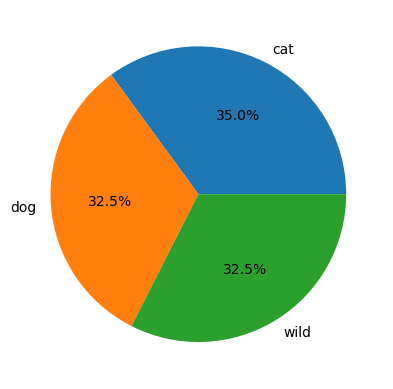

In [44]:


distribution = df["label"].value_counts().reset_index()
distribution.columns = ["label", "count"]

fig, ax = plt.subplots()
ax.pie(distribution["count"], labels=distribution["label"], autopct='%1.1f%%')
plt.show()




4. Data Split

In [45]:
train = df.sample(frac=0.7)  # Take a 70% sample of the data frame
test = df.drop(train.index)  # Take the remaining 30%

In [46]:
train

,image_path,label
10851,afhq/train/dog/pixabay_dog_002480.jpg,dog
4581,afhq/train/cat/pixabay_cat_004382.jpg,cat
9537,afhq/train/dog/flickr_dog_000168.jpg,dog
2945,afhq/train/cat/pixabay_cat_004160.jpg,cat
13750,afhq/train/wild/flickr_wild_003698.jpg,wild
...,...,...
7912,afhq/train/dog/pixabay_dog_003232.jpg,dog
4459,afhq/train/cat/flickr_cat_000563.jpg,cat
10150,afhq/train/dog/pixabay_dog_003508.jpg,dog
12790,afhq/train/wild/flickr_wild_001691.jpg,wild


In [47]:
test

,image_path,label
1,afhq/val/cat/pixabay_cat_001985.jpg,cat
4,afhq/val/cat/pixabay_cat_003562.jpg,cat
13,afhq/val/cat/pixabay_cat_000623.jpg,cat
14,afhq/val/cat/flickr_cat_000233.jpg,cat
15,afhq/val/cat/pixabay_cat_002694.jpg,cat
...,...,...
16110,afhq/train/wild/flickr_wild_001521.jpg,wild
16120,afhq/train/wild/flickr_wild_002835.jpg,wild
16126,afhq/train/wild/flickr_wild_002597.jpg,wild
16128,afhq/train/wild/flickr_wild_001562.jpg,wild


In [48]:
val = test.sample(frac=0.5)
test = test.drop(val.index)
print(train.shape)
print(test.shape)
print(val.shape)

(11291, 2)
(2419, 2)
(2420, 2)


# Label encoder

In [49]:
label_encoder = LabelEncoder()
label_encoder.fit(df["label"])

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float),
])

# Examples on how to use label encoder

In [50]:
print(list(label_encoder.classes_))
label_encoder.transform(["wild", "dog", "cat", "wild"])

['cat', 'dog', 'wild']


array([2, 1, 0, 2])

In [51]:
label_encoder.inverse_transform([2, 1, 0, 2])

array(['wild', 'dog', 'cat', 'wild'], dtype=object)

In [52]:
le = LabelEncoder()
le.fit(["paris", "paris", "tokyo", "amsterdam"])
list(le.classes_)

['amsterdam', 'paris', 'tokyo']

In [53]:
le.transform(["tokyo", "tokyo", "paris"])

array([2, 2, 1])

# Dataset class

In [54]:
class CustomImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.labels = torch.tensor(label_encoder.transform(dataframe["label"])).to(device)

    def __len__(self):
        return self.dataframe.shape[0]  #NUmber of rows

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]  # Return row "idx" and first column
        label = self.labels[idx]  # Return tensor label (from 0-2)
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image).to(device)
        return image, label


In [55]:
training_dataset = CustomImageDataset(dataframe=train, transform=transform)
val_dataset = CustomImageDataset(dataframe=val, transform=transform)
test_dataset = CustomImageDataset(dataframe=test, transform=transform)

In [56]:
test_dataset.__getitem__(0)

(tensor([[[1.0000, 1.0000, 1.0000,  ..., 0.7333, 0.6784, 0.6275],
          [1.0000, 1.0000, 1.0000,  ..., 0.8706, 0.8314, 0.7843],
          [1.0000, 1.0000, 1.0000,  ..., 0.9294, 0.8941, 0.8667],
          ...,
          [0.9686, 0.9686, 0.9686,  ..., 0.3373, 0.3804, 0.3569],
          [0.9686, 0.9686, 0.9647,  ..., 0.3216, 0.3765, 0.3882],
          [0.9686, 0.9686, 0.9647,  ..., 0.3020, 0.3294, 0.3804]],
 
         [[0.9412, 0.9412, 0.9412,  ..., 0.7137, 0.6588, 0.6000],
          [0.9412, 0.9412, 0.9412,  ..., 0.8510, 0.8078, 0.7608],
          [0.9412, 0.9412, 0.9412,  ..., 0.9020, 0.8667, 0.8392],
          ...,
          [0.9412, 0.9412, 0.9412,  ..., 0.2902, 0.3333, 0.3098],
          [0.9412, 0.9412, 0.9373,  ..., 0.2745, 0.3294, 0.3412],
          [0.9412, 0.9412, 0.9373,  ..., 0.2549, 0.2824, 0.3333]],
 
         [[0.8431, 0.8431, 0.8431,  ..., 0.7255, 0.6902, 0.6549],
          [0.8431, 0.8431, 0.8431,  ..., 0.8392, 0.8157, 0.7765],
          [0.8431, 0.8431, 0.8431,  ...,

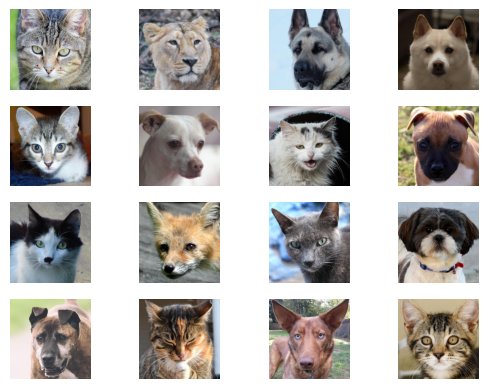

In [57]:
n_rows = 4
n_col = 4
f, axarr = plt.subplots(n_rows, n_col)
for row in range(n_rows):
    for col in range(n_col):
        image = Image.open(df.sample(n=1)["image_path"].iloc[0]).convert('RGB')
        axarr[row, col].imshow(image)
        axarr[row, col].axis("off")
plt.show()

# Hyperparameters

In [58]:
LR = 1e-4
BATCH_SIZE = 16
EPOCHS = 10

In [59]:
train_loader = DataLoader(training_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)


In [60]:
# this will return 16 samples (batch size)
for x, y in train_loader:
    print(x)
    print("---------------------------------------")
    print(y)
    break

tensor([[[[0.4157, 0.4431, 0.4588,  ..., 0.0941, 0.1059, 0.1333],
          [0.3922, 0.4196, 0.4392,  ..., 0.0745, 0.0941, 0.1451],
          [0.3804, 0.4078, 0.4235,  ..., 0.0706, 0.0863, 0.1412],
          ...,
          [0.5137, 0.5176, 0.5176,  ..., 0.3843, 0.3765, 0.3843],
          [0.5059, 0.5059, 0.5098,  ..., 0.3686, 0.3686, 0.3765],
          [0.4980, 0.4980, 0.5020,  ..., 0.3686, 0.3725, 0.3725]],

         [[0.4588, 0.4863, 0.4980,  ..., 0.0941, 0.1098, 0.1373],
          [0.4353, 0.4627, 0.4784,  ..., 0.0745, 0.0980, 0.1490],
          [0.4235, 0.4510, 0.4627,  ..., 0.0706, 0.0902, 0.1451],
          ...,
          [0.4588, 0.4627, 0.4627,  ..., 0.3294, 0.3216, 0.3294],
          [0.4510, 0.4510, 0.4549,  ..., 0.3137, 0.3137, 0.3216],
          [0.4431, 0.4431, 0.4471,  ..., 0.3137, 0.3176, 0.3176]],

         [[0.3255, 0.3647, 0.4000,  ..., 0.0784, 0.0863, 0.1098],
          [0.3020, 0.3412, 0.3804,  ..., 0.0588, 0.0745, 0.1216],
          [0.2902, 0.3294, 0.3647,  ..., 0

# Convolutional neural network

<center>
<img src = "cnn.png"/>
</center>

In [61]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  # THe more output channels the better?
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        self.pooling = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()

        self.flatten = nn.Flatten()
        self.linear = nn.Linear(128 * 16 * 16, 128)

        self.out = nn.Linear(128, len(df["label"].unique()))

    def forward(self, x):
        x = self.conv1(x)
        x = self.pooling(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.pooling(x)
        x = self.relu(x)

        x = self.conv3(x)
        x = self.pooling(x)
        x = self.relu(x)

        x = self.flatten(x)
        x = self.linear(x)
        x = self.out(x)

        return x




In [62]:
model = Net().to(device)


In [63]:
from torchsummary import summary

summary(model, input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
         MaxPool2d-2           [-1, 32, 64, 64]               0
              ReLU-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 64, 64, 64]          18,496
         MaxPool2d-5           [-1, 64, 32, 32]               0
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7          [-1, 128, 32, 32]          73,856
         MaxPool2d-8          [-1, 128, 16, 16]               0
              ReLU-9          [-1, 128, 16, 16]               0
          Flatten-10                [-1, 32768]               0
           Linear-11                  [-1, 128]       4,194,432
           Linear-12                    [-1, 3]             387
Total params: 4,288,067
Trainable params: 4,288,067
Non-trainable params: 0
---------------------------

In [64]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=LR)

In [65]:
from tqdm import tqdm
import time

total_loss_train_plot = []
total_loss_val_plot = []

total_acc_train_plot = []
total_acc_val_plot = []

for epoch in range(EPOCHS):
    start_time = time.time()

    total_acc_train = 0
    total_loss_train = 0

    total_loss_val = 0
    total_acc_val = 0

    # Progress bar for training
    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Training]", leave=False)

    for inputs, labels in train_loader_tqdm:
        optimizer.zero_grad()

        outputs = model(inputs)
        training_loss = criterion(outputs, labels)
        total_loss_train += training_loss.item()

        training_loss.backward()
        train_acc = (torch.argmax(outputs, axis=1) == labels).sum().item()
        total_acc_train += train_acc

        optimizer.step()

    # Progress bar for validation
    val_loader_tqdm = tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Validation]", leave=False)

    with torch.no_grad():
        for inputs, labels in val_loader_tqdm:
            outputs = model(inputs)
            val_loss = criterion(outputs, labels)
            total_loss_val += val_loss.item()

            val_acc = (torch.argmax(outputs, axis=1) == labels).sum().item()
            total_acc_val += val_acc

    end_time = time.time()
    epoch_duration = round(end_time - start_time, 2)

    # Logging and plotting data
    total_loss_train_plot.append(round(total_loss_train / 1000, 4))
    total_loss_val_plot.append(round(total_loss_val / 1000, 4))

    total_acc_train_plot.append(round((total_acc_train / len(training_dataset)) * 100, 4))
    total_acc_val_plot.append(round((total_acc_val / len(val_dataset)) * 100, 4))

    print(f"""
Epoch {epoch + 1}/{EPOCHS} completed in {epoch_duration} seconds
Train Loss: {round(total_loss_train / 1000, 4)} | Train Accuracy: {round((total_acc_train / len(training_dataset)) * 100, 4)}%
Val Loss: {round(total_loss_val / 1000, 4)} | Val Accuracy: {round((total_acc_val / len(val_dataset)) * 100, 4)}%
""")



Epoch 1/10 completed in 76.5 seconds
Train Loss: 0.3166 | Train Accuracy: 81.3923%
Val Loss: 0.0387 | Val Accuracy: 90.3719%




Epoch 2/10 completed in 74.16 seconds
Train Loss: 0.1351 | Train Accuracy: 93.0741%
Val Loss: 0.0302 | Val Accuracy: 92.2314%




Epoch 3/10 completed in 68.29 seconds
Train Loss: 0.0885 | Train Accuracy: 95.5274%
Val Loss: 0.0244 | Val Accuracy: 94.0496%




Epoch 4/10 completed in 68.71 seconds
Train Loss: 0.0589 | Train Accuracy: 97.0419%
Val Loss: 0.021 | Val Accuracy: 94.9587%




Epoch 5/10 completed in 68.18 seconds
Train Loss: 0.0427 | Train Accuracy: 97.9895%
Val Loss: 0.034 | Val Accuracy: 92.3554%




Epoch 6/10 completed in 67.92 seconds
Train Loss: 0.0288 | Train Accuracy: 98.7246%
Val Loss: 0.0175 | Val Accuracy: 95.9091%




Epoch 7/10 completed in 68.02 seconds
Train Loss: 0.0204 | Train Accuracy: 99.1143%
Val Loss: 0.0215 | Val Accuracy: 95.0413%




Epoch 8/10 completed in 67.89 seconds
Train Loss: 0.0142 | Train Accuracy: 99.3712%
Val Loss: 0.02 | Val Accuracy: 96.0331%




Epoch 9/10 completed in 68.03 seconds
Train Loss: 0.0103 | Train Accuracy: 99.6457%
Val Loss: 0.0192 | Val Accuracy: 96.4463%




Epoch 10/10 completed in 68.13 seconds
Train Loss: 0.0061 | Train Accuracy: 99.7254%
Val Loss: 0.0219 | Val Accuracy: 95.6612%



In [67]:
print(len(training_dataset))
print(len(val_dataset))



11291
2420
2419


In [68]:
with torch.no_grad():
    start_time = time.time()

    total_loss_test = 0
    total_acc_test = 0

    # Progress bar for testing
    test_loader_tqdm = tqdm(test_loader, desc="Testing", leave=False)

    for inputs, labels in test_loader_tqdm:
        predictions = model(inputs)
        test_acc = (torch.argmax(predictions, axis=1) == labels).sum().item()
        total_acc_test += test_acc

        test_loss = criterion(predictions, labels)
        total_loss_test += test_loss.item()

    end_time = time.time()
    test_duration = round(end_time - start_time, 2)

    print(f"""Test completed in {test_duration} seconds
Accuracy: {round((total_acc_test / len(test_dataset)) * 100, 4)}%
Loss: {round(total_loss_test / 1000, 4)}
""")

Test completed in 10.1 seconds
Accuracy: 96.0728%
Loss: 0.0192



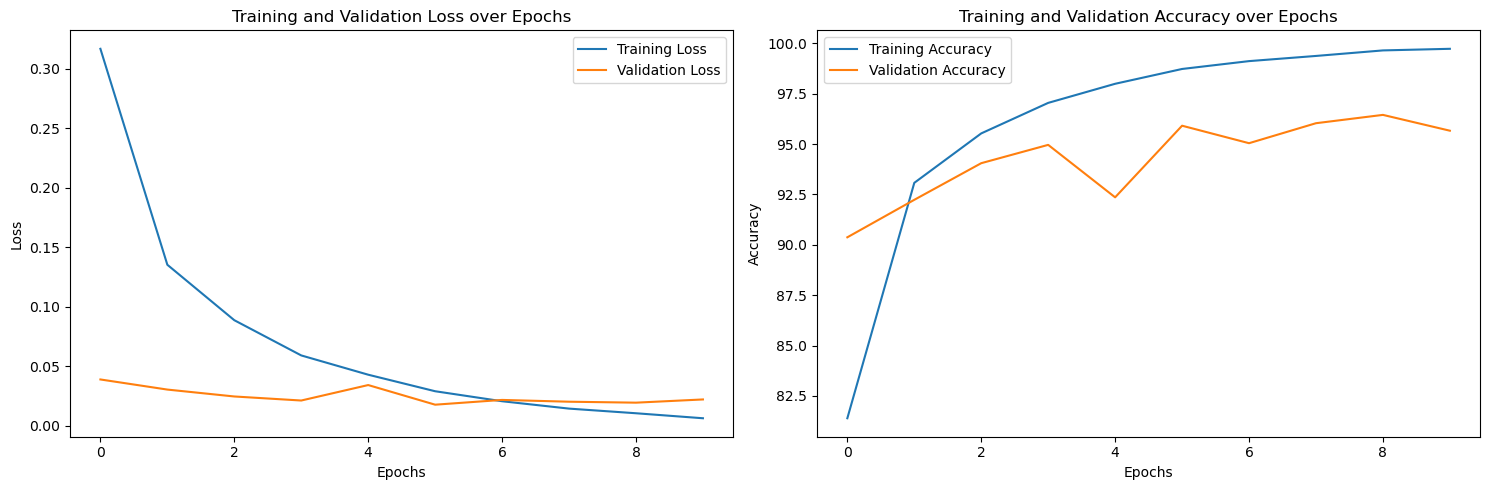

In [76]:

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(total_loss_train_plot, label='Training Loss')
axs[0].plot(total_loss_val_plot, label='Validation Loss')
axs[0].set_title('Training and Validation Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(total_acc_train_plot, label='Training Accuracy')
axs[1].plot(total_acc_val_plot, label='Validation Accuracy')
axs[1].set_title('Training and Validation Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

plt.tight_layout()

plt.show()



## 🔍 Signs of Overfitting

### 1. Training Loss Decreases, Validation Loss Increases
If you see:

- Training loss continuously decreasing
- Validation loss starts increasing after a few epochs

➡️ Your model is memorizing the training data and failing to generalize — **classic overfitting**.

---

### 2. Training Accuracy Increases, Validation Accuracy Stagnates or Drops
If:

- Training accuracy keeps going up
- Validation accuracy plateaus or decreases

➡️ The model is getting better on training data but not improving on unseen data.



# Inference
1.
2.

In [96]:
# 1. Read image
def predict_image(image_path):
    image = Image.open(image_path).convert("RGB")
    image = transform(image).to(device)
    print(image.shape)
    output=  model(image.unsqueeze(0))
    output = torch.argmax(output, dim=1).item()


    return label_encoder.inverse_transform([output])

In [100]:
result = predict_image("cat.png")
print(result)

torch.Size([3, 128, 128])
['cat']


In [109]:
result2 = predict_image("img_4.png")
print(result2)

torch.Size([3, 128, 128])
['cat']
